In [1]:
%cd ..
%ls 

from ch_est_net.preloading import *
from ch_est_net.utils import *

from torch.fft import fft, ifft, fftshift, ifftshift
from ch_est_net import activation

%load_ext autoreload
%autoreload 2

import torch
print(torch.__version__)



/home/alex/GitHub/ML_for_channel_estimation
ch_est_net/        model_image      output.svg        torchvix-sample
config_beams.yaml  model_image.png  __pycache__/      torchvix-sample.png
config.yaml        Notebooks/       README.md         train.h5
DMRS_signal/       one.pt           requirements.txt  zero_150.pt
lista_beam_net.pt  output.png       results/          zero.pt
1.10.1


In [2]:
cfg, dataL, dataS, device, deviceType, dtype, file, ml_default, onePilotFolder, path ,preload, print_function, scen0, Scenario = crazy_preloader()

Using CPU

Preload data: OK


In [3]:
def get_batch(snr_range, ind_range, seed):
    '''
    For files ind_range add noise with snr_range and stack all realizations to single array
    --------------------------------------------------------------------------
    RETURNS:
    pilot_batch -> [Realizations ; Antennas ; Subc ; Re/Im ]
    data_batch  -> [Realizations ; Antennas ; Subc ; 12? ; Re/Im]
    pilot_batch -> [Realizations]
    --------------------------------------------------------------------------
    Realizations = len(snr_range)*len(ind_range) 
    '''

    pilot_batch = torch.tensor(())
    pilot_noisy_batch = torch.tensor(())
    data_batch = torch.tensor(())
    noise_P_batch = torch.tensor(())

    for snr in snr_range:
        for ind in ind_range:
            h_pilot, h_data = data_load(scen0, dtype = dtype, onePilotFolder = onePilotFolder,dataL=dataL, ind = ind) 
                                                  # load data
            h_pilot_noisy, _ = add_noise(h_pilot, SNR = snr,scen=scen0, dtype=dtype, seed = seed)                             # add noise to pilots
            h_data_noisy, data_noise_power = add_noise_data(h_data, SNR = snr, dtype = dtype, seed = seed)     # add noise to data

            h_pilot = h_pilot.mean(dim = 2).unsqueeze(dim = 0)                                  # mean over pilots dim and add aditional dim
            h_pilot_noisy = h_pilot_noisy.mean(dim = 2).unsqueeze(dim = 0)

            h_data_noisy = h_data_noisy.unsqueeze(dim = 0)                                      # add additional dim for
            data_noise_power = data_noise_power.unsqueeze(dim =0)

            pilot_batch = torch.cat((pilot_batch, h_pilot), dim = 0)

            pilot_noisy_batch = torch.cat((pilot_noisy_batch, h_pilot_noisy), dim = 0)
            data_batch = torch.cat((data_batch, h_data_noisy), dim = 0)
            noise_P_batch = torch.cat((noise_P_batch, data_noise_power), dim = 0)

    return pilot_batch, pilot_noisy_batch, data_batch, noise_P_batch



snr_range = [-12, -10, -8 ,-5 , -2, 5, 10, 30]
x_batch, u_batch, _, _ = get_batch(snr_range = snr_range,
                                            ind_range = range(1,140,5),
                                            seed = 312)



x_test, u_test, _, _ = get_batch(snr_range = [-12, -10, -8 ,-5 , -2],
                                              ind_range = range(2, 141, 5),
                                              seed = 2)


x_batch = x_batch[:,:,:,0] + 1j*x_batch[:,:,:,1]
u_batch = u_batch[:,:,:,0] + 1j*u_batch[:,:,:,1]

x_test = x_test[:,:,:,0] + 1j*x_test[:,:,:,1]
u_test = u_test[:,:,:,0] + 1j*u_test[:,:,:,1]


In [4]:
def beam_time_transform(x):
    if len(x.shape)==2:
        x = torch.unsqueeze(x, dim = 0)

    x_a_t = ifft(x , n = 512, dim = 2, norm = 'ortho')
    x_a_t = torch.roll(x_a_t, shifts = 206, dims= 2)
    x_b_t = fft(x_a_t, n = 512, dim = 1, norm = 'ortho')

    return torch.squeeze(x_b_t, dim = 0)    

def ant_freq_transform(x):
    if len(x.shape)==2:
        x = torch.unsqueeze(x, dim = 0)
    
    x = torch.roll(x, shifts= -206, dims =2)
    x_a_t = ifft(x, n = 512, dim = 1, norm = 'ortho')
    x_a_t = x_a_t[:,:64,:]
    x_a_f = fft(x_a_t, n = 512, dim = 2, norm ='ortho')
    x_a_f = x_a_f[:,:,:48]
    
    return torch.squeeze(x_a_f, dim = 0)

from torch.nn.functional import mse_loss
def MSE(x_real, x_hat):
    '''Mean squared error generalized for complex values'''

    assert x_real.shape == x_hat.shape, 'Sizes of both values must be the same, but got {0} and {1} instead'.format(x_real.shape, x_hat.shape)
    
    if torch.is_complex(x_real):
        mse = torch.sum(torch.abs(x_real-x_hat)**2)/torch.numel(x_real)

    else:
        mse = mse_loss(x_real, x_hat)

    return mse

x_batch_spec = beam_time_transform(x_batch)
u_batch_spec = beam_time_transform(u_batch)
x_test_spec = beam_time_transform(x_test)
u_test_spec = beam_time_transform(u_test)

In [5]:

def mean_scaller(in_data):
    out_data = torch.zeros_like(in_data)
    for idx in range(in_data.shape[0]):
        out_data[idx] = in_data[idx] - torch.mean(in_data[idx])
        out_data[idx] = in_data[idx] / torch.std(in_data[idx], unbiased = False)
    return out_data 


def re_im_mean_scaller(in_data):
    out_data_re = torch.zeros_like(in_data)
    out_data_im = torch.zeros_like(in_data)
    
    for idx in range(in_data.shape[0]):
        out_data_re[idx] = in_data[idx].real - torch.mean(in_data[idx].real)
        out_data_re[idx] = in_data[idx].real / torch.std(in_data[idx].real, unbiased = False)
        
        out_data_im[idx] = in_data[idx].imag - torch.mean(in_data[idx].imag)
        out_data_im[idx] = in_data[idx].imag / torch.std(in_data[idx].imag, unbiased = False)


    return out_data_re + 1j*out_data_im 



def noise_mean_scaller(in_data):
    out_data = torch.zeros_like(in_data)
    in_data = torch.roll(in_data, shifts = 150, dims = 1)
    noise_data = in_data[:,10:150,:]

    for idx in range(in_data.shape[0]):
        out_data[idx] = in_data[idx] - torch.mean(noise_data[idx])
        out_data[idx] = in_data[idx] / torch.std(noise_data[idx], unbiased = False)
    return out_data 




In [6]:
# shape [SNR, file, beams, time]
x_batch_spec_ = torch.reshape(x_batch_spec, (len(snr_range),-1,512,512))
u_batch_spec_ = torch.reshape(u_batch_spec, (len(snr_range),-1,512,512))
x_batch_spec_scaled = torch.reshape(mean_scaller(x_batch_spec), (len(snr_range),-1,512,512))
u_batch_spec_scaled = torch.reshape(mean_scaller(u_batch_spec), (len(snr_range),-1,512,512))
x_batch_spec_noise_scaled = torch.reshape(noise_mean_scaller(x_batch_spec), (len(snr_range),-1,512,512))
u_batch_spec_noise_scaled = torch.reshape(noise_mean_scaller(u_batch_spec), (len(snr_range),-1,512,512))
x_batch_spec_re_im = torch.reshape(re_im_mean_scaller(x_batch_spec), (len(snr_range),-1,512,512))
u_batch_spec_re_im = torch.reshape(re_im_mean_scaller(u_batch_spec), (len(snr_range),-1,512,512))

In [ ]:
# -*- coding: utf-8 -*-
# 2019 1127 Modified   by S. Liu
# 2020 0321 ReModified by S. Liu
# 2022 0117 Re S. Liu

import argparse
import re
import os
import glob
import datetime
import time
import numpy as np
import torch
import h5py
from scipy import io
from utils import cov


class ComplexBN(torch.nn.Module):

    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True):
        super(ComplexBN, self).__init__()
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.eps = eps
        self.num_features = num_features
        # self.batchNorm2dF = torch.nn.BatchNorm2d(num_features,
        #                                          affine=affine).to(self.device)

    def forward(self, x):  # shpae of x : [batch,2,channel,axis1,axis2]
        # divide dim=1 to 2 parts -> real and imag
        # real/imag = [batch, channel, axis1, axis2]

        real = x[:, 0]
        imag = x[:, 1]

        realVec = torch.flatten(real)
        imagVec = torch.flatten(imag)
        re_im_stack = torch.stack((realVec, imagVec), dim=1)
        covMat = cov(re_im_stack)
        e, v = torch.symeig(covMat, True)
        covMat_sq2 = torch.mm(torch.mm(v, torch.diag(torch.pow(e, -0.5))),
                              v.t())
        data = torch.stack((realVec - real.mean(), imagVec - imag.mean()),
                           dim=1).t()
        whitenData = torch.mm(covMat_sq2, data)
        real_data = whitenData[0, :].reshape(real.shape[0], real.shape[1],
                                             real.shape[2], real.shape[3])
        imag_data = whitenData[1, :].reshape(real.shape[0], real.shape[1],
                                             real.shape[2], real.shape[3])
        output = torch.stack((real_data, imag_data), dim=1)
        return output


class ComplexConv2D(torch.nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=1,
                 bias=True):
        super(ComplexConv2D, self).__init__()
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.padding = padding

        # Model components
        # define complex conv
        self.conv_re = torch.nn.Conv2d(in_channels,
                                       out_channels,
                                       kernel_size,
                                       stride=stride,
                                       padding=padding,
                                       dilation=dilation,
                                       groups=groups,
                                       bias=bias).to(self.device)
        self.conv_im = torch.nn.Conv2d(in_channels,
                                       out_channels,
                                       kernel_size,
                                       stride=stride,
                                       padding=padding,
                                       dilation=dilation,
                                       groups=groups,
                                       bias=bias).to(self.device)
        self.weight1 = self.conv_re.weight
        self.weight2 = self.conv_im.weight
        self.bias1 = self.conv_re.bias
        self.bias2 = self.conv_im.bias

    def forward(self, x):
        paddingF = torch.nn.ZeroPad2d(1)
        # print(x.shape)
        r = paddingF(x[:, 0])  # NCHW
        i = paddingF(x[:, 1])
        # print(r.shape)
        # New 20191102
        r[:, :, 0, :], i[:, :, 0, :] = r[:, :, -2, :], i[:, :, -2, :]
        r[:, :, -1, :], i[:, :, -1, :] = r[:, :, 1, :], i[:, :, 1, :]
        r[:, :, :, 0], i[:, :, :, 0] = r[:, :, :, 2], i[:, :, :, 2]
        r[:, :, :, -1], i[:, :, :, -1] = r[:, :, :, 1], i[:, :, :, 1]
        # NEW END
        real = self.conv_re(r) - self.conv_im(i)
        # print(real.shape)
        imaginary = self.conv_re(i) + self.conv_im(r)
        # stack real and imag part together @ dim=1
        output = torch.stack((real, imaginary), dim=1)
        return output


class ComplexReLU(torch.nn.Module):

    def __init__(self, inplace=False):
        super(ComplexReLU, self).__init__()
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.relu_re = torch.nn.ReLU(inplace=inplace).to(self.device)
        self.relu_im = torch.nn.ReLU(inplace=inplace).to(self.device)

    def forward(self, x):
        output = torch.stack(
            (self.relu_re(x[:, 0]), self.relu_im(x[:, 1])), dim=1).to(self.device)
        return output


class ComplexDnCNN(torch.nn.Module):

    def __init__(self,
                 depth=17,
                 n_channels=64,
                 image_channels=1,
                 use_bnorm=True,
                 kernel_size=3):
        super(ComplexDnCNN, self).__init__()
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        # kernel_size = 3
        padding = 0
        layers = []
        # 1. Conv2d and ReLU
        layers.append(
            ComplexConv2D(in_channels=image_channels,
                          out_channels=n_channels,
                          kernel_size=kernel_size,
                          padding=padding,
                          bias=True))
        layers.append(ComplexReLU(inplace=False))
        # 2. 15 * (Conv2d + BN + ReLU)
        for _ in range(depth - 2):
            layers.append(
                ComplexConv2D(in_channels=n_channels,
                              out_channels=n_channels,
                              kernel_size=kernel_size,
                              padding=padding,
                              bias=False))
            '''layers.append(torch.nn.BatchNorm2d(
                n_channels, eps=0.0001, momentum=0.95).to(device=self.device))'''
            layers.append(ComplexBN(n_channels, eps=0.0001, momentum=0.95))
            layers.append(ComplexReLU(inplace=False))
        # 3. conv2d
        layers.append(
            ComplexConv2D(in_channels=n_channels,
                          out_channels=image_channels,
                          kernel_size=kernel_size,
                          padding=padding,
                          bias=False))
        self.dncnn = torch.nn.Sequential(*layers)

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y - out

In [7]:
import torch
import torch.nn as nn

class DnCNN(nn.Module):
    def __init__(self, channels, num_of_layers = 17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
    def forward(self, x):
        out = self.dncnn(x)
        return out


from torch.nn.functional import mse_loss

def MSE(x_real, x_hat):
    '''Mean squared error generalized for complex values'''

    assert x_real.shape == x_hat.shape, 'Sizes of both values must be the same, but got {0} and {1} instead'.format(x_real.shape, x_hat.shape)
    if torch.is_complex(x_real):
        mse = torch.sum(torch.abs(x_real-x_hat)**2)/torch.numel(x_real)

    else:
        mse = mse_loss(x_real, x_hat)

    return mse

def amplitude_MSE(x_real, x_hat):
    assert x_real.shape == x_hat.shape, 'Sizes of both values must be the same, but got {0} and {1} instead'.format(x_real.shape, x_hat.shape)
    return mse_loss(abs(x_real), abs(x_hat))

def phase_MSE(x_real,x_hat):
    assert x_real.shape == x_hat.shape, 'Sizes of both values must be the same, but got {0} and {1} instead'.format(x_real.shape, x_hat.shape)
    return mse_loss(torch.angle(x_real), torch.angle(x_hat))


In [8]:
dncnn = DnCNN(1) 
optim = torch.optim.Adam(dncnn.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer= optim,
    mode = 'min',
    factor = 0.1,
    patience = 10,
    threshold = 1e-3,
    threshold_mode = 'rel',
    cooldown = 10,
    min_lr= 1e-5
)

In [9]:
train_loss_hist, test_loss_hist = [], []
train_am_hist, test_am_hist = [], []
train_phase_hist, test_phase_hist = [], []

normalize = False

def abs_norm(data):
    rho = abs(data)
    mu = torch.mean(rho)
    psi = torch.std(rho)
    
    data = data - (mu/2 +1j*mu/2)
    data = data / psi

    return data, mu, psi 

def abs_denorm(data, mu, psi):
    data = data * psi
    data = data + (mu/2 + 1j*mu/2)
    return data

for epoch in range(1000):
    dncnn.train()
    optim.zero_grad()

    train_loss, train_loss_am, train_loss_phase = 0,0,0

    for idx in range(x_batch_spec.shape[0]):
        u = torch.unsqueeze(torch.unsqueeze(u_batch_spec[idx],0),0)
        x = torch.unsqueeze(torch.unsqueeze(x_batch_spec[idx],0),0)

        mean_u ,std_u = 0,0

        if normalize:
            u, mean_u, std_u = abs_norm(u)
        
        noisy_power = abs(u)
        signal_power = abs(x)
        noise_power = noisy_power - signal_power 

        x_hat_noise = dncnn(noisy_power)
        x_hat_mask = torch.sigmoid(noisy_power-x_hat_noise)
        x_hat = u*x_hat_noise 
        
        if normalize:
            x_hat = abs_denorm(x_hat, mean_u, std_u)
        
        train_loss += MSE(x_hat, x)
        train_loss_am += amplitude_MSE(x_hat, x)
        train_loss_phase += phase_MSE(x_hat, x)

    train_loss.backward()
    optim.step()

    train_loss_hist.append(train_loss.item())
    train_am_hist.append(train_loss_am.item())
    train_phase_hist.append(train_loss_phase.item())

    # dncnn.eval()
    # test_loss, test_loss_am , test_loss_phase = 0,0,0
    # with torch.no_grad():
    #     for idx in range(x_test_spec.shape[0]):
    #         u = torch.unsqueeze(torch.unsqueeze(u_test_spec[idx],0),0)
    #         x = torch.unsqueeze(torch.unsqueeze(x_test_spec[idx],0),0)

    #         mean_u ,std_u = 0,0

    #         if normalize:
    #             u, mean_u, std_u = abs_norm(u)
                

    #         noisy_power = abs(u)
    #         signal_power = abs(x)
    #         noise_power = noisy_power - signal_power 
            
    #         x_hat_noise = dncnn(noisy_power)
    #         x_hat_mask = torch.sigmoid(noisy_power-x_hat_noise)
    #         x_hat = u*x_hat_noise 

            
    #         if normalize:
    #             x_hat = abs_denorm(x_hat, mean_u, std_u)

    #         test_loss += MSE(x_hat, x)
    #         test_loss_am += amplitude_MSE(x_hat,x)
    #         test_loss_phase += phase_MSE(x_hat,x)

    #     test_loss.append(test_loss.item())
    #     test_loss_am.append(test_loss_am.item())
    #     test_loss_phase.append(test_loss_phase.item())
    #     scheduler.step(test_loss.item())
    
    # if scheduler.optimizer.param_groups[0]['lr'] < 1e-4:
    #     print("Min lr has been exceded")
    #     break

    print("Epoch:{} | Train Loss: {} ".format(epoch, train_loss.item))
    


In [5]:
u_batch_spec.shape

torch.Size([224, 512, 512])

In [40]:
rho = abs(x_batch_spec)
psi = torch.angle(x_batch_spec)

In [47]:
test = rho*torch.exp(1j * psi)

In [49]:
torch.isclose(x_batch_spec,test).all()

tensor(True)

In [53]:

def nothing(u): return u 

def get_detector_er(method, is_complex, dtype, onePilotFolder,dataL, ml, 
            lossVersion='detector', # 'detector' or 'relError'
            inds = range(1,141), 
            SNR_L = range(-10,-1), 
            seed = 4, 
            precoding = nothing,
            aftercoding = nothing, 
            max_iter = 3, 
            ml_version = 12, 
            SNRscaleFactor = 1.,
            scen = None, ## <- Shouldn't be none 
            scale = True):
    assert lossVersion in ['detector', 'relError']
  
    N_used = scen.RB_num*scen.RB_size
    loss = []
    comb = scen.comb

    z = torch.zeros(64, 512, 2, requires_grad = False)
    h_hat = torch.zeros(64, 512, 2, requires_grad = False) 
    j = 0

    losses = []

    if lossVersion == 'detector':
        N_pilot_sym = scen.N_pilot*scen.N_TTI
        N_data_sym = (14-N_pilot_sym)*scen.N_TTI;
        for SNR in SNR_L:
            loss_current = 0
            for ind in inds:
                h_pilot, h_data = data_load(scen, dtype = dtype, onePilotFolder = onePilotFolder,dataL = dataL, ind = ind+1 ,use_preloaded = False)
                h_pilot_noisy, _ = add_noise(h_pilot, SNR, scen = scen, dtype = dtype, seed = seed)
                h_data_noisy, data_noise_power = add_noise_data(h_data, SNR, dtype= dtype, seed = seed) 

                u = h_pilot_noisy.mean(dim=2)
                x = h_pilot.mean(dim = 2)

                # if mehtod works with complex values - transfrom dims to complex numbers                
                if is_complex:
                    u = (u[:,:,0] + 1j*u[:,:,1]).type(torch.complex64).detach()
                    x = (x[:,:,0] + 1j*x[:,:,1]).type(torch.complex64).detach()
                
                # CHANNEL ESTIMATION

                u_pred = precoding(u)
                x_pred = precoding(x)

                u_psi = torch.angle(u_pred)
                x_psi = torch.angle(x_pred)
                x_rho = abs(x_pred)
                u_rho = abs(u_pred)

                h_pilot_rec = u_rho * torch.exp(1j*x_psi)

                #x_pred /= torch.max(x_pred) 
                #x_mask = torch.zeros_like(x_pred)
                #x_mask[x_pred>0.05] = 1
                #h_pilot_rec = u_pred * x_mask
                h_pilot_rec = aftercoding(h_pilot_rec)


                if is_complex:
                    h_pilot_rec = complex_to_shape(h_pilot_rec)
                

                assert h_pilot_rec.shape[1] == N_used
                H_re = h_pilot_rec[:, :, 0]
                H_im = -h_pilot_rec[:, :, 1]
                
                # Detector error calculation
                err_data = 0
                for k in range (N_data_sym):    
                    det_data = torch.zeros((N_used, 2))   
                    assert h_data_noisy.shape[1] == N_used 
                    Y = h_data_noisy[:, :, k, :]                    
                    det_data[:,0] = (torch.sum(Y[:,:,0]*H_re-Y[:,:,1]*H_im, dim=0)/
                                    (data_noise_power+torch.sum(H_re**2+H_im**2, dim=0)))
                    det_data[:,1] = (torch.sum(Y[:,:,1]*H_re+Y[:,:,0]*H_im, dim=0)/
                                    (data_noise_power+torch.sum(H_re**2+H_im**2, dim=0)))
                      
                    err = det_data - torch.Tensor([1.,0.])  
                    err_data = err_data+torch.sum(err**2)
    
                loss_current += err_data/(N_data_sym*N_used)

                cur = {'loss': err_data.detach().numpy() ,'SNR': SNR, 'file': ind}
                losses.append(cur)

            loss.append(loss_current)        
            
    return loss, losses

In [54]:
# Вызов функции
SNR_range = range(-12,1,2)
scenario_range = range(1, 140, 2)

detector_error_beam_net_1, losses = get_detector_er(method= nothing, is_complex=True, 
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            ml = ml_default,
            SNR_L=SNR_range,
            precoding=beam_time_transform ,
            aftercoding=ant_freq_transform)


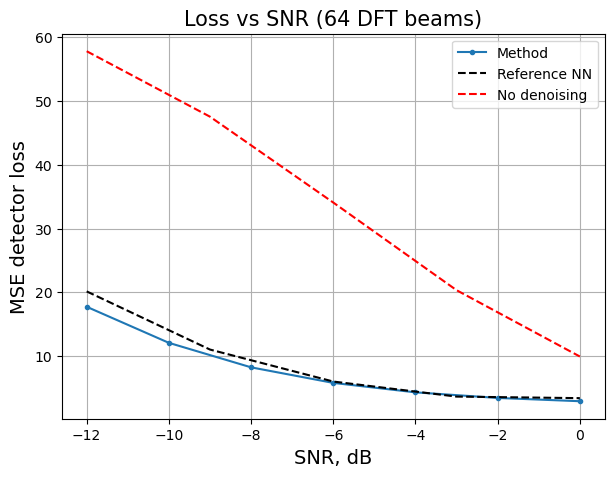

In [38]:
reference = [20.1498, 11.0312,6.0139, 3.6551, 3.4109 ]
noise = [57.8161, 47.5496, 34.0860, 20.339, 9.9376]
lista_beam_net_1 = [22.4750, 11.875, 6.335, 3.123, 2.094]
lista_beam_net_2 = [21.1612, 10.924, 6.216, 3.526, 3.194]
SNR_range = range(-12,1,2)
SNR2_range = range(-12,1,3)

import matplotlib.pyplot as plt
plt.style.use("default")

plt.figure(figsize=(7,5))
plt.plot(SNR_range,detector_error_beam_net_1,'.-' ,label = 'Method')
plt.plot(SNR2_range,reference,'--k',label = 'Reference NN' )
plt.plot(SNR2_range,noise,'--r',label = 'No denoising' )

plt.legend()
plt.title("Loss vs SNR (64 DFT beams)", fontsize = 15)
plt.xlabel("SNR, dB" , fontsize = 14)
plt.ylabel("MSE detector loss", fontsize = 14);
#plt.ylim([0 , 48])
plt.grid()


plt.show()

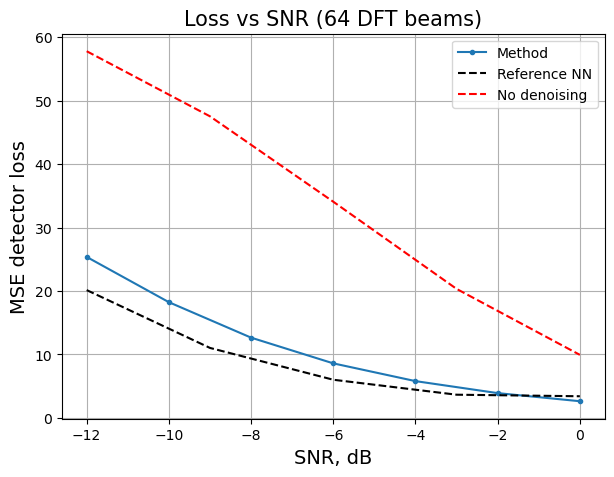

In [56]:
reference = [20.1498, 11.0312,6.0139, 3.6551, 3.4109 ]
noise = [57.8161, 47.5496, 34.0860, 20.339, 9.9376]
lista_beam_net_1 = [22.4750, 11.875, 6.335, 3.123, 2.094]
lista_beam_net_2 = [21.1612, 10.924, 6.216, 3.526, 3.194]
SNR_range = range(-12,1,2)
SNR2_range = range(-12,1,3)

import matplotlib.pyplot as plt
plt.style.use("default")

plt.figure(figsize=(7,5))
plt.plot(SNR_range,detector_error_beam_net_1,'.-' ,label = 'Method')
plt.plot(SNR2_range,reference,'--k',label = 'Reference NN' )
plt.plot(SNR2_range,noise,'--r',label = 'No denoising' )

plt.legend()
plt.title("Loss vs SNR (64 DFT beams)", fontsize = 15)
plt.xlabel("SNR, dB" , fontsize = 14)
plt.ylabel("MSE detector loss", fontsize = 14);
#plt.ylim([0 , 48])
plt.grid()


plt.show()